*Ewing et al (2020) Structural variants at the BRCA1/2 loci are a common source of homologous repair deficiency in high grade serous ovarian carcinoma*

# Notebook 8 - Differential expression between HR deficient and HR proficient tumours

This notebook covers the analyses of differential expression between HR deficient and HR proficient samples.
It comes in two parts:

- Which genes are dysregulated in the presence of HRD?
- Can we use gene expression to predict HRD?

# Which genes are dysregulated in the presence of HRD?

## Define HR proficient and HR deficient groups

In [ ]:
sampleInfo<-read.table("SampleInformation.txt",sep="\t",header=T,stringsAsFactors=F)
rownames(sampleInfo)<-sampleInfo[,1]

In [200]:
sampleInfo$Cohort<-substr(sampleInfo$Sample,1,2)

sum(is.na(sampleInfo[sampleInfo$Cohort=="DO","BRCA1_VST"])==FALSE)
sum(is.na(sampleInfo[sampleInfo$Cohort=="AO","BRCA1_VST"])==FALSE)
sum(is.na(sampleInfo[sampleInfo$Cohort=="SH","BRCA1_VST"])==FALSE)


AO DO SH 
80 44 81 

[1] 30

[1] 80

[1] 40

### HR deficient

In [ ]:
brca_snvs<-sampleInfo[sampleInfo$BRCAstatus=="Germline SNV" | sampleInfo$BRCAstatus=="Somatic SNV","Sample"]

### HR proficient

In [204]:
samples_germline_HR<-read.table("HGSOC_samples_with_germline_expandedHR_SNV.txt",sep="\t")
samples_germline_HR<-as.character(samples_germline_HR[,1])

In [ ]:
samples_somatic_HR<-read.table("/Volumes/igmm/HGS-OvarianCancerA-SGP-WGS/BRCA1_BRCA2_SVs_paper/Analysis/RNAseq/differentialExpression_HR/HGSOC_samples_with_somatic_expandedHR_SNV.txt",sep="\t")
samples_somatic_HR<-as.character(samples_somatic_HR[,1])

In [ ]:
hrsnvs<-union(samples_germline_HR,samples_somatic_HR)

In [ ]:
prof<-sampleInfo[setdiff(sampleInfo$Sample,hrsnvs),]
prof2<-prof[prof$BRCAstatus=="None",]
prof3<-prof2[prof2$ReSig_3==0 & prof2$ReSig_5==0,]
dim(prof3)
hr_proficient_samps<-prof3$Sample

## Load RNA quantifications from salmon

In [ ]:
require(tximport)
require(DESeq2)

In [33]:
files_scot<-dir("SHGSOC/salmon",pattern="quant.sf",recursive = T,full.names = TRUE)
files_aocs<-dir("AOCS/salmon",pattern="quant.sf",recursive = T,full.names = TRUE)
files_tcga<-dir("TCGA_US_OV/salmon",pattern="quant.sf",recursive = T,full.names = TRUE)
files<-c(files_scot,files_scot_additional,files_aocs,files_tcga)

rna_reps_to_exclude<-read.table("RNAseq_replicates_forexclusion.txt",sep="\t")
rna_reps_to_exclude<-as.character(rna_reps_to_exclude[,1])

new_files_orig<-setdiff(files,rna_reps_to_exclude)
tx2knownGene <- read.csv("tx2gene.csv",header = F)

names(new_files_orig)[1:37]<-do.call("cbind",strsplit(new_files_orig[1:37],split = "[/.]"))[10,]
names(new_files_orig)[38:42]<-do.call("cbind",strsplit(new_files_orig[38:42],split = "[/.]"))[10,]
names(new_files_orig)[43:122]<-do.call("cbind",strsplit(new_files_orig[43:122],split = "[/.]"))[6,]
names(new_files_orig)[123:152]<-do.call("cbind",strsplit(new_files_orig[123:152],split = "[/.]"))[10,]

txi.salmon <- tximport(new_files_orig, type = "salmon", tx2gene = tx2knownGene)

In [ ]:
sample<-read.table("SampleInformation.txt",sep="\t",header=T,stringsAsFactors=F)
sample_expr<-sample

rna_sampleids<-colnames(head(txi.salmon$counts))
rna_short_sampleids<-rep(NA,length(rna_sampleids))
rna_short_sampleids[1:42]<-substr(rna_sampleids[1:42],1,9)
rna_short_sampleids[43:122]<-substr(rna_sampleids[43:122],1,8)
rna_short_sampleids[123:152]<-substr(rna_sampleids[123:152],1,7)
rna<-data.frame(RNA_sample=rna_sampleids,Sample=rna_short_sampleids)
rna<-rna[as.character(rna$Sample) %in% as.character(sample_expr$Sample),]

new_files<-new_files_orig[as.character(rna$RNA_sample)]

txi.salmon2 <- tximport(new_files, type = "salmon", tx2gene = tx2knownGene)

## Set up condition

In [208]:
coldata<-merge(rna,sample_expr,by="Sample",all.x=T)
coldata$HRDtruth<-"Excluded"
coldata[(coldata$Sample %in% hr_deficient_conservative),"HRDtruth"]<-"HRDef"
coldata[(coldata$Sample %in% hr_proficient_samps),"HRDtruth"]<-"HRProf"
table(coldata$HRDtruth)
coldata$Cohort<-substr(as.character(coldata$Sample),1,2)

rownames(coldata)<-as.character(coldata$RNA_sample)

coldata[is.na(coldata$BRCA1status),"BRCA1status"]<-"Excluded"
coldata[is.na(coldata$BRCA2status),"BRCA2status"]<-"Excluded"
coldata<-coldata[as.character(rna$RNA_sample),]


coldata$condition<-factor(coldata$HRDtruth)
rownames(coldata)<-c(1:150)

dds <- DESeqDataSetFromTximport(txi.salmon2, 
                               colData = coldata,
                                design=~Cohort+Purity+condition)


Excluded    HRDef   HRProf 
      74       42       34 

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”using counts and average transcript lengths from tximport


## Run DESeq2 to identify DE genes between HRD and HR proficient groups

In [209]:
HRD<-which(coldata$condition!="Excluded")
ddsHRD<-dds[,HRD]
colData(ddsHRD)$condition<-droplevels(colData(ddsHRD)$condition)
ddsHRD <- DESeq(ddsHRD)
res<-results(ddsHRD)

estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


## Filter to only protein coding genes

In [211]:
biom_res<-read.table("All_genes_quant_type.txt",sep="\t",header=T)
rownames(biom_res)<-as.character(biom_res[,1])
protein_coding_genes<-as.character(biom_res[biom_res$Gene.type=="protein_coding",1])

In [213]:
resLFC <- lfcShrink(ddsHRD[protein_coding_genes,], coef="condition_HRProf_vs_HRDef",type="ashr")

resLFC$new.padj<-p.adjust(resLFC$pvalue, method="BH",n=length(protein_coding_genes))

res001<- resLFC[is.na(resLFC$padj)==FALSE & resLFC$new.padj<0.05 & abs(resLFC$log2FoldChange)>1,]
res001_ord<-res001[order(res001$new.padj),]

DE_genes_ensembl<-biom_res[rownames(res001_ord),1]

length(DE_genes_ensembl)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041


[1] 306

No HR genes.

## Transform expression counts to visualise difference in DE genes between HRD and HR prof samples

In [ ]:
dds_correct <- DESeqDataSetFromTximport(txi.salmon2, 
                               colData = coldata,
                                design=~Purity+as.factor(Cohort))
dds_correct <- DESeq(dds_correct)
vsd <- vst(dds_correct , blind=FALSE)
protein_coding_vsd<-assay(vsd)[protein_coding_genes,]

## PCA on DE genes to capture main patterns of variation

In [ ]:
p<-prcomp(t(protein_coding_vsd[as.character(DE_genes_ensembl),HRD]))

## Scatter and boxplot of main axis of variation in expression of DE genes in HRD and HR proficient samples

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


	Wilcoxon rank sum test

data:  pca_dat$PC1 by as.factor(pca_dat$condition)
W = 114, p-value = 3.375e-12
alternative hypothesis: true location shift is not equal to 0


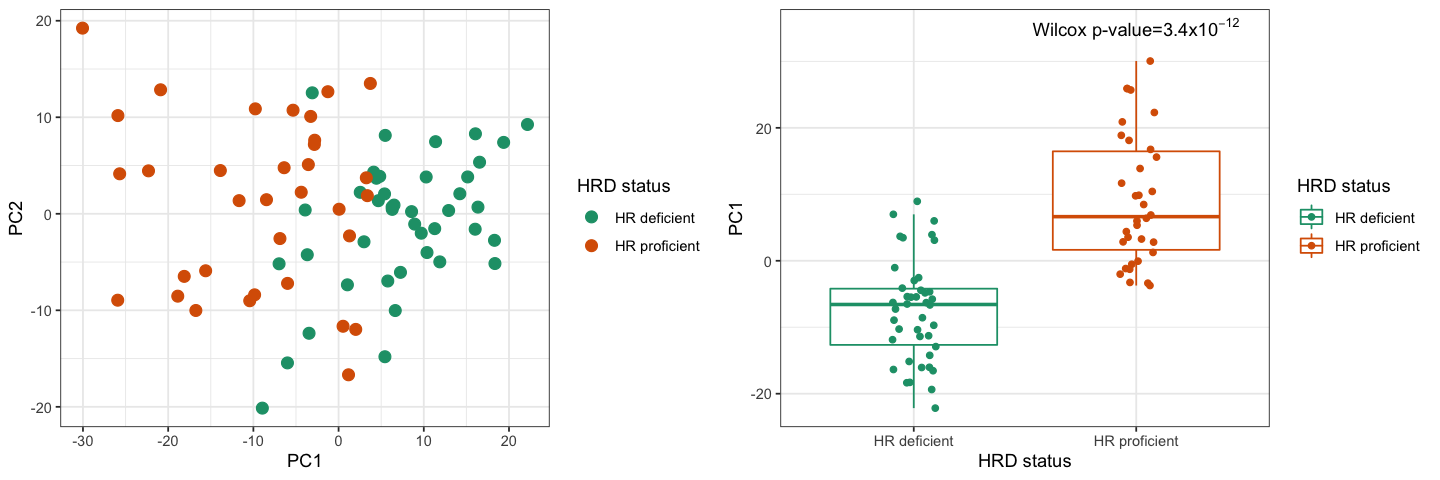

In [97]:
options(repr.plot.width=7,repr.plot.height=4)
pcaData <- plotPCA(vsd, intgroup=c("condition", "Cohort"), returnData=TRUE)
pcaData<-pcaData[HRD,]
pca_dat<-data.frame(condition=as.character(pcaData$condition),p$x[,1:10])

library(ggplot2)
library(gridExtra)

gscatter<-ggplot(pca_dat, aes(-PC1, PC2, color=condition)) +
geom_point(size=3) +
  xlab("PC1") + 
theme_bw()+
scale_colour_brewer(breaks=c("HRDef", "HRProf"),labels=c("HR deficient","HR proficient"),type="qual",palette="Dark2",name="HRD status")+
 ylab("PC2") 


gbox<-ggplot(pca_dat, aes(x=condition, y=PC1, color=condition)) +
geom_boxplot(outlier.shape=NA)+geom_jitter(width=0.1)+
  ylab("PC1") + 
annotate("text",x=2,y=35,label=expression(paste("Wilcox p-value=3.4x",10^-12)))+
scale_colour_brewer(breaks=c("HRDef", "HRProf"),labels=c("HR deficient","HR proficient"),palette="Dark2",name="HRD status")+
theme_bw()+
scale_x_discrete(labels=c("HR deficient","HR proficient"),name="HRD status")

options(repr.plot.width=12)
grid.arrange(gscatter,gbox,nrow=1)

wilcox.test(pca_dat$PC1~as.factor(pca_dat$condition))

# Can we use gene expression to predict HRD?

DESeq2 on 80% of dataset to identify DE genes then run PCA on those genes and see whether PC1 splits the data by HRD status. Apply to the training (80%) and then test set (20%)

In [100]:
dds_cohortspec <- DESeqDataSetFromTximport(txi.salmon2, 
                               colData = coldata,
                                design=~Cohort+Purity+condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”using counts and average transcript lengths from tximport


## Partition the data

In [127]:
set.seed(20)
HRDcomp_train_def<-sample(which(coldata$condition=="HRDef"),0.8*length(which(coldata$condition=="HRDef")))
HRDcomp_train_prof<-sample(which(coldata$condition=="HRProf"),0.8*length(which(coldata$condition=="HRProf")))

ground_truth_train<-c(HRDcomp_train_def,HRDcomp_train_prof)

HRDcomp_80<-c(HRDcomp_train_def,HRDcomp_train_prof,sample(which(coldata$condition=="Excluded"),0.8*length(which(coldata$condition!="Excluded"))))
HRDcomp_20<-rownames(coldata[-HRDcomp_80,])

length(HRDcomp_80)
length(HRDcomp_20)


[1] 120

[1] 30

## DE on only training set

In [111]:
ddsHRDcomp_tr<-dds_cohortspec[,ground_truth_train]
colData(ddsHRDcomp_tr)$condition<-droplevels(colData(ddsHRDcomp_tr)$condition)
ddsHRDcomp_tr <- DESeq(ddsHRDcomp_tr)
res_80<-results(ddsHRDcomp_tr)

estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [113]:
resLFC <- lfcShrink(ddsHRDcomp_tr[protein_coding_genes,], coef="condition_HRProf_vs_HRDef",type="ashr")

resLFC$new.padj<-p.adjust(resLFC$pvalue, method="BH",n=length(protein_coding_genes))

res001<- resLFC[is.na(resLFC$padj)==FALSE & resLFC$new.padj<0.05 & abs(resLFC$log2FoldChange)>1,]
res001_ord<-res001[order(res001$new.padj),]

DE_genes_ensembl<-biom_res[rownames(res001_ord),1]
length(DE_genes_ensembl)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041


[1] 325

## Transform expression counts and PCA on DE genes in training set

In [114]:
dds_correct <- DESeqDataSetFromTximport(txi.salmon2, 
                               colData = coldata,
                                design=~Purity+as.factor(Cohort))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”using counts and average transcript lengths from tximport


In [115]:
dds_correct <- DESeq(dds_correct)

estimating size factors
using 'avgTxLength' from assays(dds), correcting for library size
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [116]:
vsd <- vst(dds_correct , blind=FALSE)

In [117]:
protein_coding_vsd<-assay(vsd)[protein_coding_genes,]

In [146]:
protein_coding_vsd_80<-protein_coding_vsd[,HRDcomp_80]


In [ ]:
p<-prcomp(t(protein_coding_vsd_80[as.character(DE_genes_ensembl),]))

## Performance in training set

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


	Wilcoxon rank sum test

data:  pca_dat_75[pca_dat_75$condition != "Excluded", "PC1"] by as.factor(pca_dat_75[pca_dat_75$condition != "Excluded", "condition"])
W = 63, p-value = 2.281e-10
alternative hypothesis: true location shift is not equal to 0


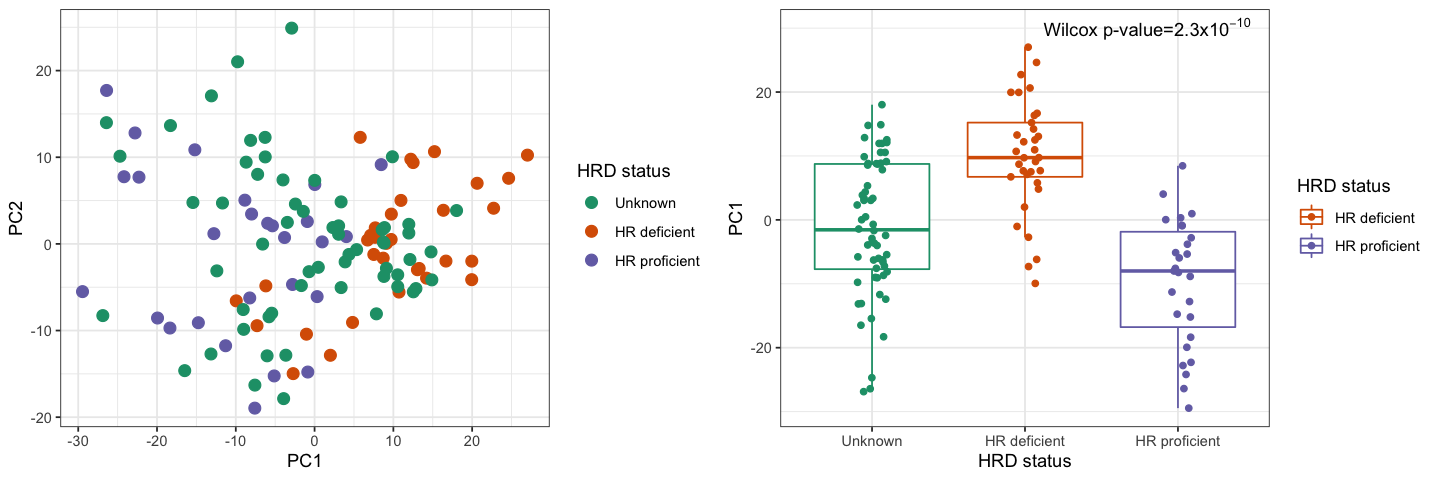

In [155]:
options(repr.plot.width=7,repr.plot.height=4)
pcaData <- plotPCA(vsd, intgroup=c("condition", "Cohort"), returnData=TRUE)
pcaData_80<-pcaData[HRDcomp_80,]
pca_dat_80<-data.frame(condition=as.character(pcaData_80$condition),p$x[,1:10])

library(ggplot2)
library(gridExtra)

gscatter_tr<-ggplot(pca_dat_80, aes(-PC1, PC2, color=condition)) +
geom_point(size=3) +
  xlab("PC1") + 
theme_bw()+
scale_colour_brewer(breaks=c("Excluded", "HRDef","HRProf"),labels=c("Unknown","HR deficient","HR proficient"),type="qual",palette="Dark2",name="HRD status")+
 ylab("PC2") 


gbox_tr<-ggplot(pca_dat_80, aes(x=condition, y=-PC1, color=condition)) +
geom_boxplot(outlier.shape=NA)+geom_jitter(width=0.1)+
  ylab("PC1") + 
annotate("text",x=2.8,y=30,label=expression(paste("Wilcox p-value=2.3x",10^-10)))+
scale_colour_brewer(breaks=c("Unknown","HRDef", "HRProf"),labels=c("Unknown","HR deficient","HR proficient"),palette="Dark2",name="HRD status")+
theme_bw()+
scale_x_discrete(labels=c("Unknown","HR deficient","HR proficient"),name="HRD status")

options(repr.plot.width=12)
grid.arrange(gscatter_tr,gbox_tr,nrow=1)

wilcox.test(pca_dat_80[pca_dat_80$condition!="Excluded","PC1"]~as.factor(pca_dat_80[pca_dat_80$condition!="Excluded","condition"]))

## PCA of test set using DE genes from training set

In [157]:
protein_coding_vsd_20<-protein_coding_vsd[,as.numeric(HRDcomp_20)]
p<-prcomp(t(protein_coding_vsd_20[as.character(DE_genes_ensembl),]))

## Performance in test set

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


	Wilcoxon rank sum test

data:  pca_dat_25[pca_dat_25$condition != "Excluded", "PC1"] by as.factor(pca_dat_25[pca_dat_25$condition != "Excluded", "condition"])
W = 30, p-value = 0.9182
alternative hypothesis: true location shift is not equal to 0


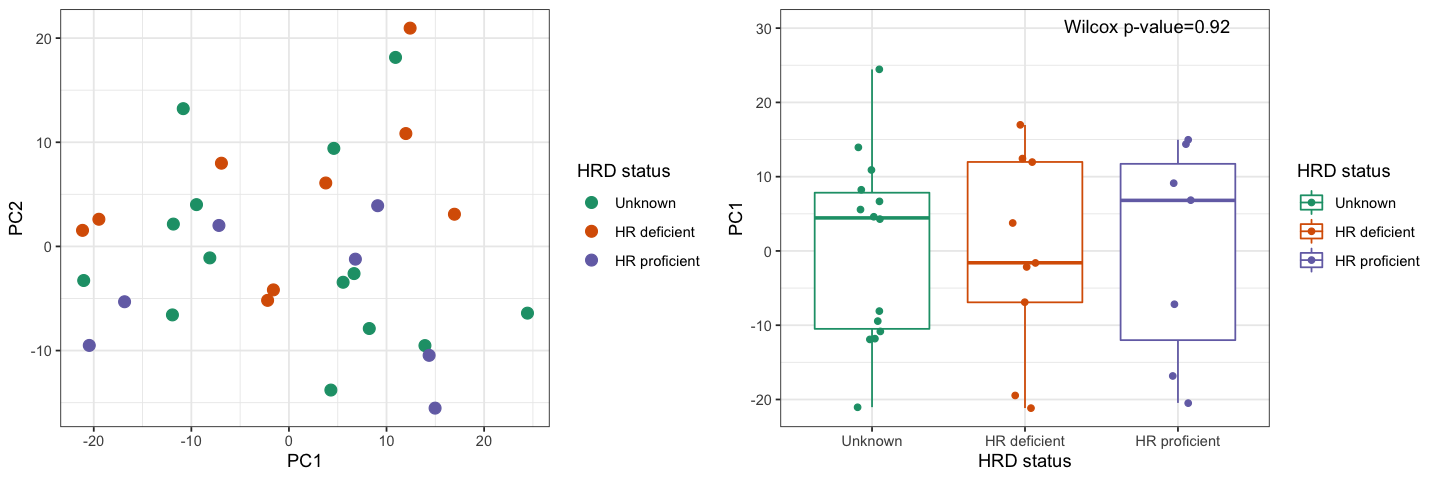

In [164]:
options(repr.plot.width=7,repr.plot.height=4)
pcaData <- plotPCA(vsd, intgroup=c("condition", "Cohort"), returnData=TRUE)
pcaData_20<-pcaData[as.numeric(HRDcomp_20),]
pca_dat_20<-data.frame(condition=as.character(pcaData_20$condition),p$x[,1:10])

library(ggplot2)
library(gridExtra)

gscatter_te<-ggplot(pca_dat_20, aes(PC1, PC2, color=condition)) +
geom_point(size=3) +
  xlab("PC1") + 
theme_bw()+
scale_colour_brewer(breaks=c("Excluded","HRDef", "HRProf"),labels=c("Unknown","HR deficient","HR proficient"),type="qual",palette="Dark2",name="HRD status")+
 ylab("PC2") 


gbox_te<-ggplot(pca_dat_20, aes(x=condition, y=PC1, color=condition)) +
geom_boxplot(outlier.shape=NA)+geom_jitter(width=0.1)+
  ylab("PC1")  + annotate("text",x=2.8,y=30,label=expression(paste("Wilcox p-value=0.92")))+
scale_colour_brewer(breaks=c("Excluded","HRDef", "HRProf"),labels=c("Unknown","HR deficient","HR proficient"),palette="Dark2",name="HRD status")+
theme_bw()+
scale_x_discrete(labels=c("Unknown","HR deficient","HR proficient"),name="HRD status")

options(repr.plot.width=12)
grid.arrange(gscatter_te,gbox_te,nrow=1)

wilcox.test(pca_dat_20[pca_dat_20$condition!="Excluded","PC1"]~as.factor(pca_dat_20[pca_dat_20$condition!="Excluded","condition"]))

## Combine plots

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”

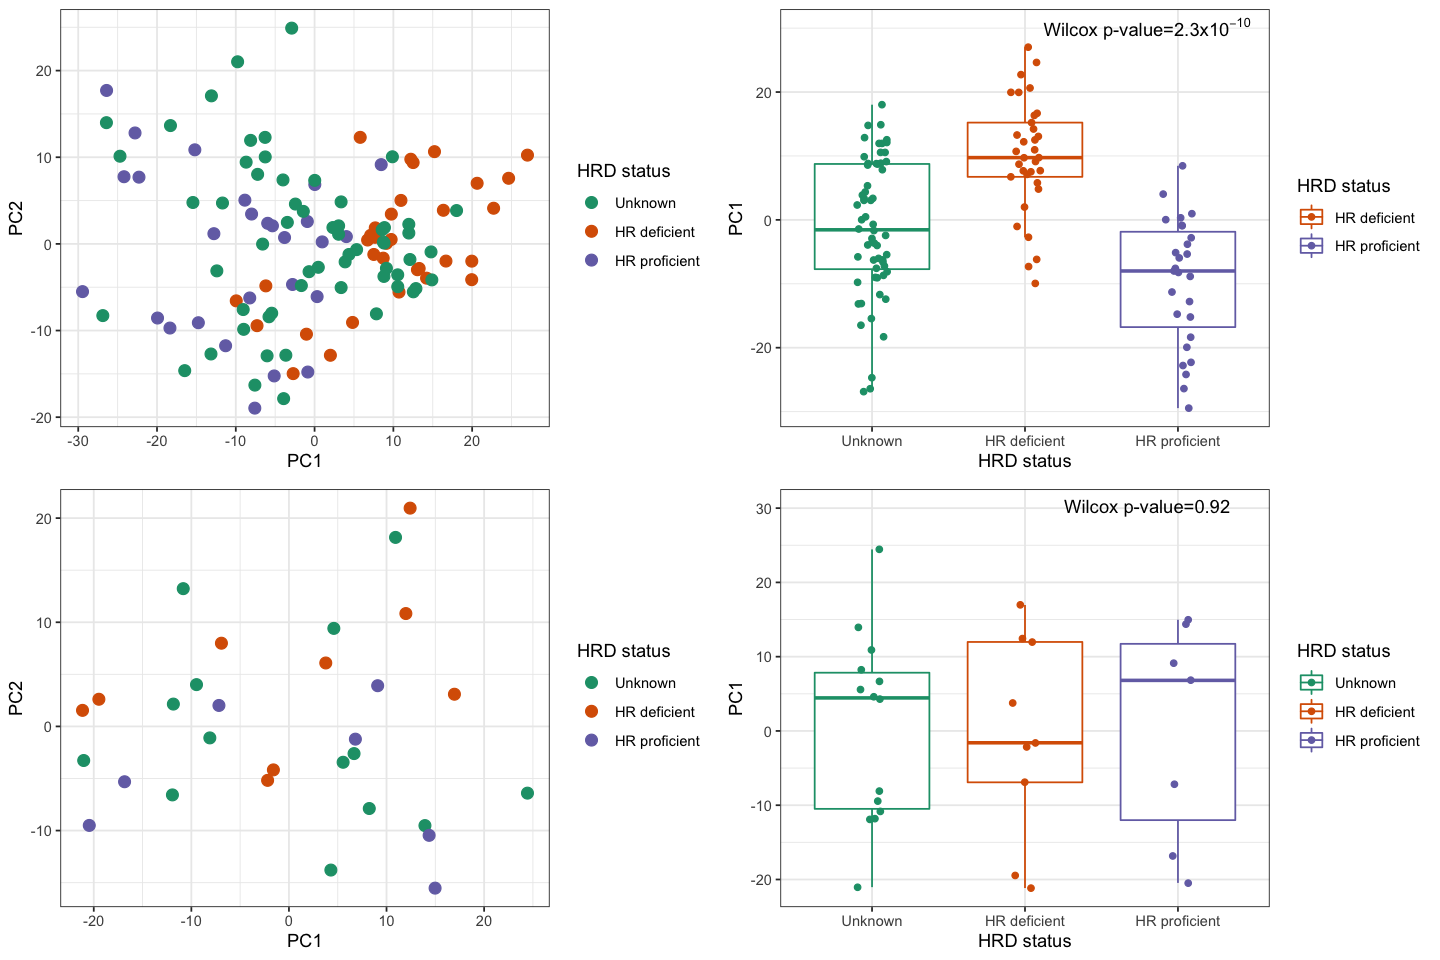

In [168]:
options(repr.plot.height=8)
grid.arrange(gscatter_tr,gbox_tr,gscatter_te,gbox_te,nrow=2)


# Gene ontology of differentially expressed genes

In [ ]:
degenes<-as.data.frame(res001_ord)

In [ ]:
library(clusterProfiler)

In [179]:
ego <- enrichGO(gene         = rownames(degenes),
                OrgDb         = 'org.Hs.eg.db',
                universe      = protein_coding_genes,
                keyType       = 'ENSEMBL',
                ont           = "CC",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.1)

summary(ego)

In [185]:
kegg_gene_ids<-read.table("~/Downloads/mart_export (8).txt",sep="\t",header=T)
kegg_gene_ids<-as.character(kegg_gene_ids[,5])

ego <- enrichKEGG(gene         = kegg_gene_ids,
                organism    = 'hsa',
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.1)


In [183]:
summary(ego)

Warning message in summary(ego):
“summary method to convert the object to data.frame is deprecated, please use as.data.frame instead.”

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
